In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from utilities import *
from grid_cell_utilities import *
from ripser import ripser
import umap
import plotly.express as px

In [2]:
with open('GridCellDictionary3June2025.pkl', 'rb') as file:
    GridCellDictionary = pickle.load(file)

In [3]:
GridCellDictionary[0]['fully_processed_rate_map'].shape

(100, 100)

In [37]:
grid_cell_samples = sample_grid_cell_dictionary(GridCellDictionary, [10, 10, 0, 10, 140])

In [38]:
num_neurons = len(grid_cell_samples)
rate_map_tensor = np.zeros((100, 100, num_neurons))

for list_index, neuron_index in enumerate(grid_cell_samples):
    rate_map = GridCellDictionary[neuron_index]['fully_processed_rate_map']
    rate_map_tensor[:, :, list_index] = rate_map

In [39]:
sample_walk = make_standard_walk_in_square_enclosure(100000, -.7, .7, -.7, .7)
sample_walk_as_matrix_indices = convert_walk_in_square_enclosure_to_list_of_matrix_indices(100000, sample_walk, -.7, .7, -.7, .7, 100, 100)

In [40]:
response_matrix = compute_grid_cell_response_given_rate_map_tensor_and_walk_as_matrix_indices(rate_map_tensor, sample_walk_as_matrix_indices)

In [41]:
corr_matrix = np.corrcoef(response_matrix)

In [42]:
corr_matrix = (corr_matrix - np.min(corr_matrix))/(np.max(corr_matrix) - np.min(corr_matrix))
dissim_mat = 1 - corr_matrix

In [43]:
result = ripser(dissim_mat, distance_matrix=True)
diagrams = result['dgms']

/var/folders/sm/cshn459n1mbb5zpdj5vfx1180000gn/T/ipykernel_38201/3576554044.py:4: MatplotlibDeprecationWarning:

Passing the marker parameter of scatter() positionally is deprecated since Matplotlib 3.10; the parameter will become keyword-only in 3.12.



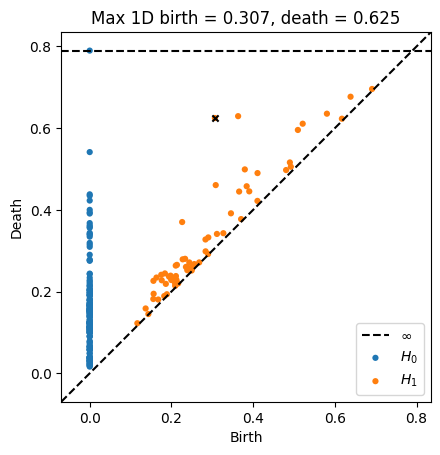

In [44]:
dgm1 = diagrams[1]
idx = np.argmax(dgm1[:, 1] - dgm1[:, 0])
plot_diagrams(diagrams, show = False)
plt.scatter(dgm1[idx, 0], dgm1[idx, 1], 20, 'k', 'x')
plt.title("Max 1D birth = %.3g, death = %.3g"%(dgm1[idx, 0], dgm1[idx, 1]))
plt.show()

In [48]:
reducer = umap.UMAP(n_neighbors=15, n_components=3, random_state=42)

In [49]:
embedding = reducer.fit_transform(dissim_mat)

/opt/homebrew/Caskroom/miniconda/base/envs/SIAMAG25/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [50]:
# Convert to Plotly-friendly format
fig = px.scatter_3d(
    x=embedding[:, 0],
    y=embedding[:, 1],
    z=embedding[:, 2],
    title='3D UMAP Projection',
    opacity=0.7
)

fig.show()